In [54]:
import sys
import matplotlib.pyplot as plt
import numpy as np
import os
import scipy
import scipy.special
import cv2

import torch

import networkx as nx

import pickle
from PIL import Image, ImageDraw
import matplotlib.lines as lines
from tqdm import tqdm
import glob

import statistics 

from skimage.transform import rotate
from sklearn.neighbors import KDTree
from scipy.spatial import distance

np.seterr(all='raise')
scipy.special.seterr(all='raise')

{'singular': 'raise',
 'underflow': 'raise',
 'overflow': 'raise',
 'slow': 'raise',
 'loss': 'raise',
 'no_result': 'raise',
 'domain': 'raise',
 'arg': 'raise',
 'other': 'raise'}

In [21]:
#Class object for network:
'''contains: the base image
the adjacency list
the graph
notable properties calculated on initialize
clustering (to be fixed) on call
visualization functions for graph on image and graph alone'''

class network_object:
    #network object - takes in a (full) segmentation output and initializes a network-object with notable properties calculated
    #
    
    def __init__(self, instances, tag, img = None):
        
        self.image = img
        self.instances = instances
        self.tag = tag
        
        #boxes = np.array(instances['pred_boxes'])
        #polygons = np.array(instances['pred_masks'])
        #scores = np.array(instances['scores'])
        
        self.number = len(self.instances['pred_boxes'])
        self.density = self.number/(instances['image_size'][0]*instances['image_size'][1])
        self.avgscore = sum(self.instances['scores'])/self.number
        
        self.densityHistogram = 0
        self.centroid_list = self.construct_centroid_list(self.instances)
        #self.polygon_list = self.construct_polygon_list(self.instances)
        
        self.adjacency_list = self.construct_adjacencies(self.instances)
        
        self.graph = self.construct_graph(self.adjacency_list)
        
        self.num_components = len(self.get_component_masses())
        
        
    def construct_centroid_list(self, instances):
        return np.array([ (((box[0]+box[2])/2).item() , ((box[1]+box[3])/2).item()) for box in instances["pred_boxes"] ])
    
    def construct_polygon_list(self, instances):
        return [ np.reshape(mask[0], (int(len(mask[0])/2) , 2)) for mask in instances["pred_masks"] ]
        
    #Definition of mindist parameter -------------------------------------------------------------------------------------
    def construct_adjacencies(self, instances, mindist = 10):
        #takes a list of n cell_poly objects
        #takes a minimum distance defined as adjacent
        #returns an adjacency list of length n

        adjacency_list = []
        wide_list = []

        centroid_list = [ (((box[0]+box[2])/2).item() , ((box[1]+box[3])/2).item()) for box in instances["pred_boxes"] ]
        centroid_list = np.array(centroid_list)
        polygon_list = [ np.reshape(mask[0], (int(len(mask[0])/2) , 2)) for mask in instances["pred_masks"] ]

        tree = []
        tree = KDTree(centroid_list, leaf_size=10)

        wide_list = tree.query_radius(centroid_list, mindist * 5)

        for i,small_list in enumerate(wide_list):
            adjacency_list.append (list())
            for index in small_list:
                # if we've already explored this pair then skip (as cdist _should_ be symmetrical)
                if index <= i:
                    continue
                d = distance.cdist(polygon_list[i],polygon_list[index],'euclidean')
                if min(d.flatten()) < mindist:
                    adjacency_list[i].append (index)

        return adjacency_list
        
    def construct_graph(self, adjacency_list):
        g = nx.Graph()
        for i in range(len(adjacency_list)):
            g.add_node(i)

        for a in range(len(adjacency_list)):
            for b in adjacency_list[a]:
                if g.has_edge(a,b):
                    continue
                g.add_edge(a,b)
        return g
    
    def average_degree(self):
        return sum([len(sublist) for sublist in self.adjacency_list])/self.number
                                                                         
    def degree_variance(self):
        numadj = [len(sublist) for sublist in self.adjacency_list]
        return statistics.variance(numadj)
        
    def plot_degree(self):
        num_adjacencies = [len(sublist) for sublist in self.adjacency_list]
        fig = plt.figure()
        plt.hist(num_adjacencies, max(num_adjacencies))
        fig.suptitle('Number of adjacent cells')
        plt.xlabel('# neighbors')
        plt.ylabel('count')
        
    def calc_fractal_dim(self, threshold=0.9):
        print('not yet implemented')
        
    def calc_entropy(self):
        print('not yet implemented')
    
    def get_component_masses(self):
        components_g = nx.connected_components(self.graph)
        gc = []
        for component in components_g:
            gc.append(len(component))
        return sorted(gc)
    
    def get_max_comp_mass(self):
        return self.get_component_masses()[-1]
        
    def visualize_adjacencies(self, img = None, savefig = 0):
        fig, ax = plt.subplots()
        if self.image is None and img is None:
            return 0
        elif self.image is None:
            ax.imshow(img, cmap=plt.cm.gray)
        else:
            ax.imshow(self.image, cmap=plt.cm.gray)
        
        for a,i in enumerate(self.adjacency_list):
            for b in i:
                plt.plot([self.centroid_list[a][0],self.centroid_list[b][0]], [self.centroid_list[a][1],self.centroid_list[b][1]], color = 'b', linewidth = .2)
        if savefig != 0:
            plt.savefig('out.png', bbox_inches='tight', dpi = 300)
        plt.show()
        
    def visualize_graph(self):
        nx.draw_networkx(self.graph, node_size = 5, node_color = 'r' , width = .5, font_size = 8, with_labels = True)
        
    ## Call to get fit parameters for each instance
    def fit_power(self):
        from scipy.optimize import curve_fit
        components = self.get_component_masses()
        def func(x, a, b):
            return a * np.power(x,b)
            #C not necessary if zero clusters = 0----------------------------------------------------------------
            
        

        bins = np.histogram(components, bins=np.logspace(np.log10(1),np.log10(max(components)), int(np.log10(max(components)*10000000))))
        xdata = []
        ydata = []
        for i in range(len(bins[1])-1):
            xdata.append(bins[1][i+1]-bins[1][i])
        ydata = np.divide(bins[0],np.array(xdata))

        popt, pcov = curve_fit(func, xdata, ydata, p0=[500,-2], maxfev=5000)#---------------------------------

        perr = np.sqrt(np.diag(pcov))
        modelPredictions = func(xdata, *popt) 
        absError = modelPredictions - ydata
        SE = np.square(absError) # squared errors
        MSE = np.mean(SE) # mean squared errors
        RMSE = np.sqrt(MSE) # Root Mean Squared Error, RMSE
        Rsquared = 1.0 - (np.var(absError) / np.var(ydata))

        return popt, Rsquared, RMSE, pcov, perr, xdata, ydata
    
    def pickle_object(self):
        #pickle the whole object
        return 0

In [55]:
#Class object for Lineage Data:
'''
For one cell lineage over multiple passages
contains in level:
cell lineage - tag
list of passages
list of days
list of network objects

'''

class lineage:
    #lineage: reads in data from instances arranged in file tree as:
        #passages
            #days
                #instances - read in and intialize network_object
                #images(optional)
    
    
    def __init__(self, filepath, tag):
        
        self.tag = tag
        
        self.items = self.read_in(filepath)
        
    def read_in(self, filepath):
        result = []
        for passage_path in sorted(glob.glob(filepath+'/*/')):
            print(passage_path)
            days = []
            for day_path in sorted(glob.glob(passage_path+'*/')):
                print(day_path)
                networks = []
                for instance_path in sorted(glob.glob(day_path+'*.data')):
                    instances = {}
                    with open(instance_path, 'rb') as filehandle:
                        instances = pickle.load(filehandle)
                    print(instance_path)
                    networks.append(network_object(instances, instance_path))
                days.append(networks)
            result.append(days)
        return result
    

    def pickle_object(self):
        #pickle the whole object
        return 0

In [62]:
class lineage_timeless:
    def __init__(self, filepath, tag):
        self.items = self.read_in(filepath)
        self.tag = tag
        
    def read_in(self, filepath):
        result = []
        for instance_path in tqdm(sorted(glob.glob(filepath+'/**/*.data',recursive = True)), desc = filepath):
            instances = {}
            with open(instance_path, 'rb') as filehandle:
                instances = pickle.load(filehandle)
            #print(instance_path)
            result.append(network_object(instances, instance_path))
        return result
    
    ## to be called from lineage: plots instance power exp to density
    def plot_fit_params(self, ax1in = None, ax2in = None):

        density = []
        popt = []
        Rsquared = []

        for network in self.items:
            try:
                popt_temp, Rsquared_temp, RMSE, pcov, perr, xdata, ydata = network.fit_power()
            except RuntimeError:
                popt_temp = [float('nan'),float('nan')]
                Rsquared_temp = float('nan')
            
            popt.append(popt_temp)
            Rsquared.append(Rsquared_temp)
            density.append(network.density)

        if ax1in is not None and ax2in is not None:
            ax1=ax1in
            ax2=ax2in
        else:
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

        ax1.plot(density,Rsquared,'.',label = self.tag)
        ax1.set_title("Rsquared to density")
        ax2.plot(density,[param[1] for param in popt],'.',label = self.tag)
        ax2.set_title("critical exponent to density")
        
        #plt.suptitle(lineage.tag + '_' + mindist)
        #plt.savefig(output+'_'+mindist+'.png')
        #plt.show()
    
    def load_object(self):
        f = open(self.filename, 'rb')
        tmp_dict = pickle.load(f)
        f.close()          

        self.__dict__.update(tmp_dict) 

    def save_object(self):
        f = open(self.filename, 'wb')
        pickle.dump(self.__dict__, f, 2)
        f.close()
        
        
            

In [65]:

toppath = "/home/trevor/Documents/group_parental/YM-P"
YMP = lineage_timeless(toppath, 'YUMM Parental')

toppath = "/home/trevor/Documents/group_parental/YMR-P"
YMRP = lineage_timeless(toppath, 'YUMMER Parental')

toppath = "/home/trevor/Documents/SCC_timelapse/07"
lineage_07 = lineage_timeless(toppath, 'lineage_07')

toppath = "/home/trevor/Documents/SCC_timelapse/14"
lineage_14 = lineage_timeless(toppath, 'lineage_14')

toppath = "/home/trevor/Documents/SCC_timelapse/21"
lineage_21 = lineage_timeless(toppath, 'lineage_21')

toppath = "/home/trevor/Documents/SCC_timelapse/20"
lineage_20 = lineage_timeless(toppath, 'lineage_20')

toppath = "/home/trevor/Documents/SCC_timelapse/11"
lineage_11 = lineage_timeless(toppath, 'lineage_11')

toppath = "/home/trevor/Documents/SCC_timelapse/25"
lineage_25 = lineage_timeless(toppath, 'lineage_25')

toppath = "/home/trevor/Documents/SCC_timelapse/28"
lineage_28 = lineage_timeless(toppath, 'lineage_28')

toppath = "/home/trevor/Documents/SCC_timelapse/38"
lineage_38 = lineage_timeless(toppath, 'lineage_38')

toppath = "/home/trevor/Documents/SCC_timelapse/41"
lineage_41 = lineage_timeless(toppath, 'lineage_41')


/home/trevor/Documents/SCC_timelapse/21: 100%|██████████| 20/20 [00:12<00:00,  1.55it/s]


'\ntoppath = "/home/trevor/Documents/SCC_timelapse/11"\nlineage_11 = lineage_timeless(toppath, \'lineage_11\')\n\ntoppath = "/home/trevor/Documents/SCC_timelapse/25"\nlineage_25 = lineage_timeless(toppath, \'lineage_25\')\n\ntoppath = "/home/trevor/Documents/SCC_timelapse/28"\nlineage_28 = lineage_timeless(toppath, \'lineage_28\')\n\ntoppath = "/home/trevor/Documents/SCC_timelapse/38"\nlineage_38 = lineage_timeless(toppath, \'lineage_38\')\n\ntoppath = "/home/trevor/Documents/SCC_timelapse/41"\nlineage_41 = lineage_timeless(toppath, \'lineage_41\')\n'

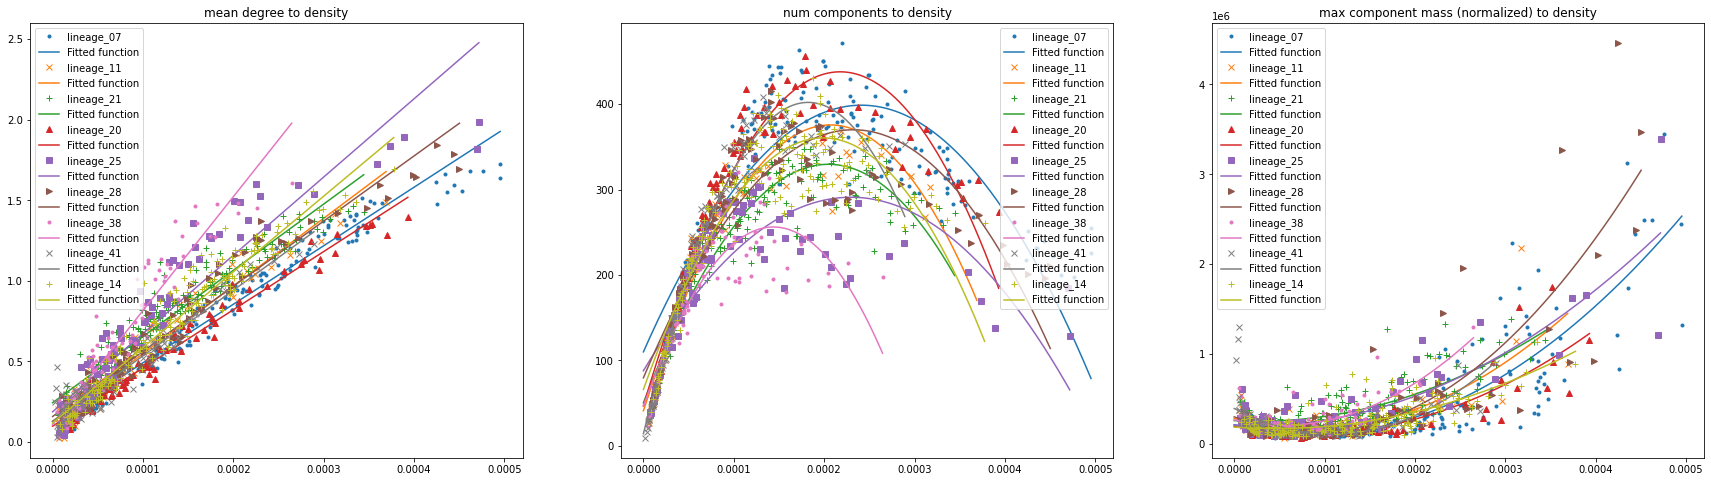

In [101]:
import itertools

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30, 8))
#ALL
#lineage_list = [YMP, YMRP, lineage_07, lineage_11, lineage_21, lineage_20, lineage_25, lineage_28, lineage_38, lineage_41, lineage_14]
#PARENTAL ONLY
#lineage_list = [YMP, YMRP]
#ORIGINAL 3
#lineage_list = [lineage_07, lineage_21, lineage_14]
#9 SCC LINEAGES
lineage_list = [lineage_07, lineage_11, lineage_21, lineage_20, lineage_25, lineage_28, lineage_38, lineage_41, lineage_14]

symbols = ['.','x','+','^','s','>']


def polyfit_rough(xdata,ydata,pdegree = 1, axes = None, color = None):
    popt = np.polyfit(xdata, ydata, pdegree)#---------------------------------
    t = np.linspace(0, max(xdata), 1000)
    axes.plot(t, np.poly1d(popt)(t), label="Fitted function", color = color)

i = 0
ax1.set_title("mean degree to density")
for lineage in lineage_list:
    density = [network.density for network in lineage.items]
    degree = [network.average_degree() for network in lineage.items]

    degree = [degree for _,degree in sorted(zip(density,degree))]
    density = sorted(density)
    color=next(ax1._get_lines.prop_cycler)['color']
    ax1.plot(density,degree, symbols[i%6], label = lineage.tag, color = color)
    
    polyfit_rough(density,degree,pdegree=1,axes = ax1, color = color)
    i += 1
ax1.legend()

i = 0
ax2.set_title("num components to density")
for lineage in lineage_list:
    density = [network.density for network in lineage.items]
    num_components = [network.num_components for network in lineage.items]

    num_components = [num_components for _,num_components in sorted(zip(density,num_components))]
    density = sorted(density)
    color=next(ax2._get_lines.prop_cycler)['color']
    ax2.plot(density,num_components, symbols[i%6], label = lineage.tag, color = color)
    
    polyfit_rough(density,num_components,pdegree=2,axes = ax2, color = color)
    i += 1
ax2.legend()

i = 0
ax3.set_title("max component mass (normalized) to density")
for lineage in lineage_list:
    density = [network.density for network in lineage.items]
    max_mass = [network.get_max_comp_mass() for network in lineage.items]

    max_mass = [max_mass for _,max_mass in sorted(zip(density,max_mass))]
    density = sorted(density)
    
    max_mass = np.divide(max_mass,density)
    color=next(ax3._get_lines.prop_cycler)['color']
    ax3.plot(density,max_mass, symbols[i%6], label = lineage.tag, color = color)
    
    polyfit_rough(density,max_mass,pdegree=2,axes = ax3, color = color)

    i += 1
ax3.legend()


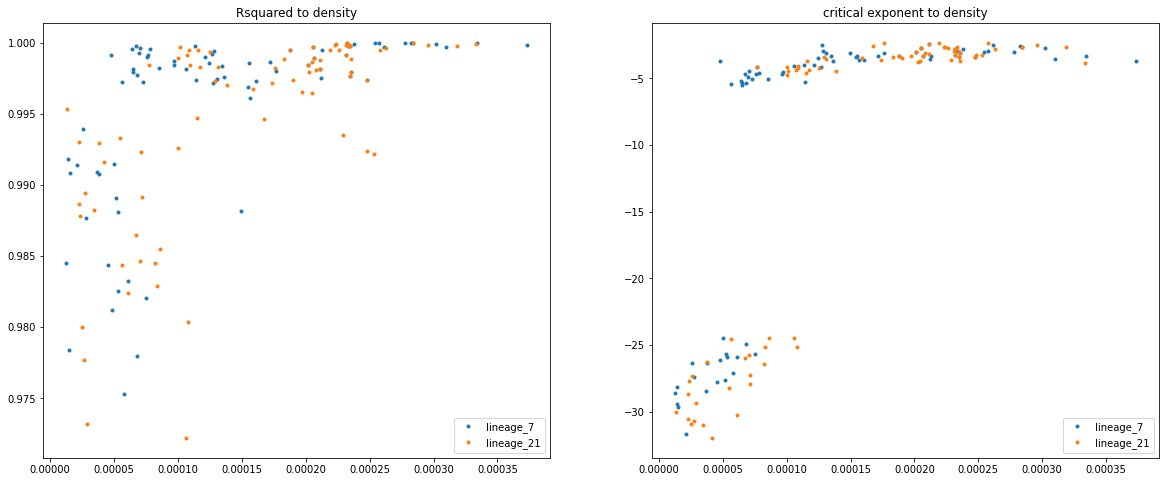

In [29]:
##TEMP, DELETE WHEN DONE
fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(20, 8))

lineage_7.plot_fit_params(ax1in=ax1,ax2in=ax2)

lineage_21.plot_fit_params(ax1in=ax1,ax2in=ax2)

ax1.legend()
ax2.legend()

In [ ]:
def plot_to_density(lineage_list, method = None, title = 'property to density', symbols = ['.','x','+','^','s'], axes = None):
    
    if (ax is not None):
        ax = axes
    else:
        fig, ax = plt.subplots(1, 1, figsize=(10, 8))
    
    i = 0
    ax.set_title(title)
    for lineage in lineage_list:
        density = [network.density for network in lineage.items]
        prop = [network.method.call() for network in lineage.items]

        prop = [prop for _,prop in sorted(zip(density,prop))]
        density = sorted(density)

        ax.plot(density,prop, symbols[i], label = lineage.tag)
        i += 1
    ax.legend()

In [47]:
#Curve Fitting And Comparison
#include power fitting as a method in networks: return fit function parameters and pererrs,
#plotting as a separate lineage method:
## Call to get fit parameters for each instance
def fit_power(network):
    from scipy.optimize import curve_fit
    components = network.get_component_masses()
    
    fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(20, 8))

    ax1.set_xscale('log')
    ax1.set_yscale('log')
    ax1.set_xlabel('cluster size')
    ax1.set_ylabel('Cluster Mass CDF')
    ax1.set_title('Cluster mass cumulative distribution function (log-log scale)')
    #ax2.set_xscale('log')
    #ax2.set_yscale('log')
    ax2.set_xlabel('cluster size')
    ax2.set_ylabel('Cluster Mass CDF')
    ax2.set_title('Cluster mass cumulative distribution function')
    
    #----------point plotting
    maxlen = max(components)
    data = np.zeros(maxlen+1)
    for pt in components:
        data[pt] += 1
    xdata = [index for index in range(len(data)) if data[index] != 0 ]
    ydata = [data[index] for index in range(len(data)) if data[index] != 0]
    ax1.plot(xdata, ydata, 'o', label='data')
    ax2.plot(xdata, ydata, 'o', label='data')
    
    
    def func(x, a, b):
        return a * np.power(x,b)
        #C not necessary if zero clusters = 0----------------------------------------------------------------
    
    #bins = np.histogram(components, bins = np.logspace(1.0, max(components), num = int(np.log10(max(components)))))
    bins = np.histogram(components, bins=np.logspace(np.log10(1),np.log10(max(components)), int(np.log10(max(components)*10000000))))
    xdata = []
    ydata = []
    for i in range(len(bins[1])-1):
        xdata.append(bins[1][i+1]-bins[1][i])
    ydata = np.divide(bins[0],np.array(xdata))
    
    #plotting hist
    ax1.plot(bins[1][0:len(bins[1])-1],ydata)
    ax2.plot(bins[1][0:len(bins[1])-1],ydata)
    
    popt, pcov = curve_fit(func, xdata, ydata, p0=[500,-2], maxfev=5000)#---------------------------------
    
    perr = np.sqrt(np.diag(pcov))
    modelPredictions = func(xdata, *popt)
    absError = modelPredictions - ydata
    SE = np.square(absError) # squared errors
    MSE = np.mean(SE) # mean squared errors
    RMSE = np.sqrt(MSE) # Root Mean Squared Error, RMSE
    Rsquared = 1.0 - (np.var(absError) / np.var(ydata))
    
    #plotting fit function
    t = np.linspace(1, max(components), 10000)
    ax1.plot(t, func(t, *popt), label="Fitted function")
    ax2.plot(t, func(t, *popt), label="Fitted function")
    
    return popt, Rsquared, RMSE, pcov, perr, xdata, ydata
    
## to be called from lineage: plots instance power exp to density
def plot_fit_params(lineage, output = None, mindist = None):
    
    density = []
    popt = []
    Rsquared = []
    
    for network in lineage.items:
        popt_temp, Rsquared_temp, RMSE, pcov, perr, xdata, ydata = network.fit_power()
        popt.append(popt_temp)
        Rsquared.append(Rsquared_temp)
        density.append(network.density)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

    ax1.plot(density,Rsquared,'.',label = lineage.tag)
    
    ax2.plot(density,popt[1],'.',label = lineage.tag)
    
    
    #plt.suptitle(lineage.tag + '_' + mindist)
    #plt.savefig(output+'_'+mindist+'.png')
    #plt.show()


ValueError: `ydata` must not be empty!

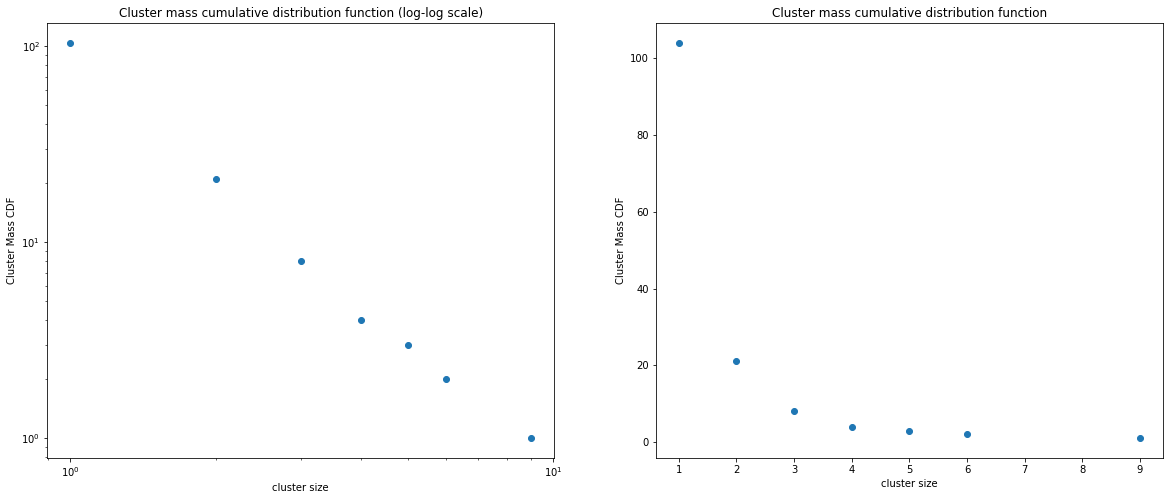

In [48]:
a = fit_power(YMRP.items[20])
print("critical exp = " + str(a[0][1]))
print("Rsquared value = " + str(a[1]))

In [79]:
# Analyze and compare multiple lineages passed as a list:

#lineagelist = [lineage_hypo, lineage_iso, lineage_hyper]


def analyze_lineage_list(lineagelist, distance_param = None, outputfile = None):


    comp_density = []
    comp_normalized_degree = []
    comp_normalized_color = []
    comp_normalized_max_mass = []
    comp_normalized_num_components = []

    for lineage in lineagelist:
        density = []
        average_degree = []
        color = []
        components = []


        for day_list in lineage.items:
            tempdensity = []
            tempdegree = []
            tempcolor = []
            tempcomponents = []

            #for instance in day_list[0]:
            for instance in day_list[3]:#-------------------------------------------------------------------------------------------
                #print(instance.tag)
                a = nx.coloring.greedy_color(instance.graph, strategy=nx.coloring.strategy_largest_first)

                tempdensity.append(instance.density)
                tempdegree.append(instance.average_degree())
                tempcolor.append(max(a.values()))
                tempcomponents.append(instance.get_component_masses())

            density.append(tempdensity)
            average_degree.append(tempdegree)
            color.append(tempcolor)
            components.append(tempcomponents)


        density = np.transpose(np.asarray(density))
        average_degree = np.transpose(np.asarray(average_degree))
        color = np.transpose(np.asarray(color))
        components = np.transpose(np.asarray(components))
        
        
        print(average_degree)
        print(density)
        normalized_degree = np.divide(average_degree,density)
        normalized_color = np.divide(color,density)

        '''average_degree = np.divide(average_degree,np.sqrt(density))
        color = np.divide(color,np.sqrt(density))'''

        fig, ((ax1, ax2, ax3),(ax4,ax5,ax6), (ax7,ax8,ax9)) = plt.subplots(3, 3, figsize=(16, 12))

        bp = ax1.boxplot(normalized_degree, notch = True)
        bp = ax2.boxplot(normalized_color, notch = True)
        bp = ax3.boxplot(density, notch = True)
        bp = ax4.boxplot(average_degree, notch = True)
        bp = ax5.boxplot(color, notch = True)

        maxcomps = []
        numcomps = []
        for day_comps in components:
            tempmaxcomps = []
            tempnumcomps = []
            for single_comps in day_comps: 
                comps = np.asarray(single_comps)
                ax9.step(comps , np.divide((np.arange(np.asarray(comps).size)),len(comps)))
                plt.xscale('log')
                plt.xlabel('cluster size (log scale)')
                plt.ylabel('Cluster Mass CDF')

                tempmaxcomps.append(max(comps)/sum(comps))
                tempnumcomps.append(len(comps))

            maxcomps.append(tempmaxcomps)
            numcomps.append(tempnumcomps)

        maxcomps = np.asarray(maxcomps)
        numcomps = np.divide(np.asarray(numcomps),density)

        bp = ax7.boxplot(maxcomps, notch = True)
        bp = ax8.boxplot(numcomps, notch = True)
        ax7.set_title('Max Cluster Mass normalized to Total Mass')
        ax8.set_title('Cluster Number / Density')


        ax3.set_title('density')
        ax1.set_title('Mean degree normalized to density')
        ax2.set_title('Chromatic number normalized to density')
        ax4.set_title('mean degree')
        ax5.set_title('chromatic number')

        fig.suptitle(lineage.tag + '_' + outputfile + '_' + distance_param, fontsize=14)
        plt.savefig(lineage.tag+ '_' + outputfile + '_' + distance_param + '.png')

        #Append to comparison matrices
        comp_density.append(density.flatten())
        comp_normalized_degree.append(normalized_degree.flatten())
        comp_normalized_color.append(normalized_color.flatten())
        comp_normalized_max_mass.append(maxcomps.flatten())
        comp_normalized_num_components.append(numcomps.flatten())



    fig, ((ax1, ax2, ax3),(ax4,ax5,ax6)) = plt.subplots(2, 3, figsize=(16, 12))

    bp = ax1.boxplot(comp_density, notch = True)
    bp = ax2.boxplot(comp_normalized_degree, notch = True)
    bp = ax3.boxplot(comp_normalized_color, notch = True)
    bp = ax4.boxplot(comp_normalized_max_mass, notch = True)
    bp = ax5.boxplot(comp_normalized_num_components, notch = True)

    ax1.set_title('density')
    ax2.set_title('Mean degree normalized to density')
    ax3.set_title('Chromatic number normalized to density')
    ax4.set_title('Mass of max component normalized to total mass')
    ax5.set_title('Number of components normalized to density')

    fig.suptitle(outputfile + '_' + 'cutoffdist_' + distance_param, fontsize=14)
    plt.savefig('compare_' + outputfile + '_' + distance_param + '.png')


In [75]:
#Curve Fitting And Comparison

from scipy.optimize import curve_fit


def hist_binning(lineage, output = None, mindist = None):
    
    #components = [np.asarray(item.get_component_masses()) for item in lineage.items[3][3]] #flattened component list
    components = [[np.asarray(item.get_component_masses()) for item in lineage.items[index][3]] 
                  for index in range(len(lineage.items))]
    #print(len(components))
    #print(components[0])
    #maxlen = max([max([max(comp) for comp in passage_components]) for passage_components in components])
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

    ax1.set_xscale('log')
    ax1.set_yscale('log')
    ax1.set_xlabel('cluster size (log scale)')
    ax1.set_ylabel('Cluster Mass CDF')
    
    ax2.set_xscale('log')
    ax2.set_yscale('log')
    
    def func(x, a, b):
            return a * np.power(x,b)
            #C not necessary if zero clusters = 0----------------------------------------------------------------
    
    popt_ = []
    pcov_ = []
    perr_ = []
    RMSE_ = []
    Rsquared_ = []
    
    
    for component in components:
        complete = []
        for comp in component:
            for c in comp:
                complete.append(c)
        complete = sorted(complete)
        #print(complete)
        bins = np.histogram(comp, bins=np.logspace(np.log10(1),np.log10(max(comp)), int(np.log10(max(comp)*100000000))))
        #ax1.hist(comp, bins=np.logspace(np.log10(1),np.log10(max(comp)), 10))
        #ax1.step(bins[1][0:len(bins[1])-1],bins[0])
        
        xdata = []
        ydata = []
        for i in range(len(bins[1])-1):
            xdata.append(bins[1][i+1]-bins[1][i])
        ydata = np.divide(bins[0],np.array(xdata))
        
        ax1.plot(bins[1][0:len(bins[1])-1],ydata)
        #ax1.plot(bins[1][0:len(bins[1])-1],bins[0])
        #print(bins)
        ax1.set_xscale("log")
        
        
        
        
        #popt, pcov = curve_fit(func3, xdata, ydata, p0=[1,-1,1], maxfev = 5000)
        popt, pcov = curve_fit(func, xdata, ydata, p0=[500,-2], maxfev=5000)#---------------------------------
        t = np.linspace(1, 1000, 10000)
        #ax2.plot(t, func3(t, *popt), label="Fitted powerfunc")
        ax2.plot(t, func(t, *popt), label="Fitted function")


        perr = np.sqrt(np.diag(pcov))
        modelPredictions = func(xdata, *popt) 
        absError = modelPredictions - ydata
        SE = np.square(absError) # squared errors
        MSE = np.mean(SE) # mean squared errors
        RMSE = np.sqrt(MSE) # Root Mean Squared Error, RMSE
        Rsquared = 1.0 - (np.var(absError) / np.var(ydata))
        
        popt_.append(popt)
        pcov_.append(pcov)
        perr_.append(perr)
        RMSE_.append(RMSE)
        Rsquared_.append(Rsquared)

        
        
        
    plt.figtext(.65,.52,'y = a * x^b + c', size = 10)
    plt.figtext(.69,.48, ["{:.3f}".format(p[1]) for p in popt_], size = 8)
    plt.figtext(.69,.44, ["{:.3f}".format(p[1]) for p in perr_], size = 8)
    plt.figtext(.65,.48, 'popt', size = 8)
    plt.figtext(.65,.44, 'perr', size = 8)
    plt.figtext(.69,.40,["{:.5f}".format(r) for r in RMSE_], size = 9)
    plt.figtext(.69,.36,["{:.5f}".format(r) for r in Rsquared_], size = 9)
    plt.figtext(.65,.40, 'RMSE', size = 8)
    plt.figtext(.65,.36, 'Rsquared', size = 8)

    ax2.legend(loc='upper right')
    plt.suptitle(lineage.tag + '_' + mindist)
    plt.savefig(output+'_'+mindist+'.png')
    plt.show()
          
    
    return (popt_, perr_, Rsquared_)

In [76]:
lineagelist = [lineage_7, lineage_21]
#lineagelist = [lineage_hypo, lineage_iso, lineage_hyper]
#analyze_lineage_list(lineagelist, distance_param = '15', outputfile = 'osmotic_analysis')

'''opt_params = []
a = curve_fit_plot(lineage_hypo, 
                output = 'hypo_curveParams', mindist = '15')
opt_params.append((a[0][0][1],a[1][0][1]))
a = curve_fit_plot(lineage_iso, 
                output = 'iso_curveParams', mindist = '15')
opt_params.append((a[0][0][1],a[1][0][1]))
a = curve_fit_plot(lineage_hyper, 
                output = 'hyper_curveParams', mindist = '15')
opt_params.append((a[0][0][1],a[1][0][1]))

'''
opt_params = []
a = hist_binning(lineage_7, output = 'hypo_curveParams', mindist = '15')
opt_params.append((a[0][0][1],a[1][0][1]))
a = hist_binning(lineage_21, output = 'hypo_curveParams', mindist = '15')
opt_params.append((a[0][0][1],a[1][0][1]))


#plt.errorbar([1,2,3], [param[0] for param in opt_params], [err[1] for err in opt_params])

bp = plt.boxplot(opt_params, notch = True)

from scipy import stats
print(stats.ttest_ind(opt_params[0],opt_params[1]))



TypeError: 'network_object' object is not subscriptable